### aim: 

### date: 

In [36]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [37]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [38]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## calculate seasonal extremes for UKESM

### there are some problems with the mesh mask

In [39]:
cdomask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_krg.nc')
rmask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmaskKURVA.nc')
tmask = cdomask.aream2.mean(dim = 'time_counter')

In [40]:
print(np.nansum(rmask.aream2.values))
print(np.nansum(tmask.values))

4330689300000000.0
1023619150000000.0


In [41]:
print(np.nansum(rmask.aream2[0,0:37,:].values))
print(np.nansum(cdomask.aream2[0,0:50,:].values))

47639307000000.0
177158000000000.0


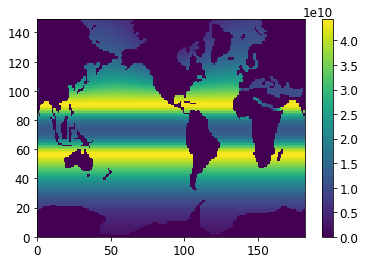

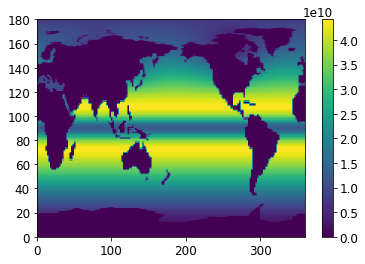

In [42]:
plt.figure()
w = plt.pcolormesh(rmask.aream2[0,:,:].values)
plt.colorbar(w)
plt.figure()
w = plt.pcolormesh(cdomask.aream2[0,:,:].values)
plt.colorbar(w)

In [43]:
def polygon_area(lats, lons, radius = 6378.137):
    """
    Computes area of spherical polygon, assuming spherical Earth. 
    Returns result in ratio of the sphere's area if the radius is specified.
    Otherwise, in the units of provided radius.
    lats and lons are in degrees.
    """
    from numpy import arctan2, cos, sin, sqrt, pi, power, append, diff, deg2rad
    lats = np.deg2rad(lats)
    lons = np.deg2rad(lons)

    # Line integral based on Green's Theorem, assumes spherical Earth

    #close polygon
    if lats[0]!=lats[-1]:
        lats = append(lats, lats[0])
        lons = append(lons, lons[0])

    #colatitudes relative to (0,0)
    a = sin(lats/2)**2 + cos(lats)* sin(lons/2)**2
    colat = 2*arctan2( sqrt(a), sqrt(1-a) )

    #azimuths relative to (0,0)
    az = arctan2(cos(lats) * sin(lons), sin(lats)) % (2*pi)

    # Calculate diffs
    # daz = diff(az) % (2*pi)
    daz = diff(az)
    daz = (daz + pi) % (2 * pi) - pi

    deltas=diff(colat)/2
    colat=colat[0:-1]+deltas

    # Perform integral
    integrands = (1-cos(colat)) * daz

    # Integrate 
    area = abs(sum(integrands))/(4*pi)

    area = min(area,1-area)
    if radius is not None: #return in units of radius
        return area * 4*pi*radius**2
    else: #return in ratio of sphere total area
        return area

In [44]:
area = polygon_area([55,56,56,55],[20,20,21,21])
print(area)

210289.01861879905


511207893.3958111
511207893395811.0


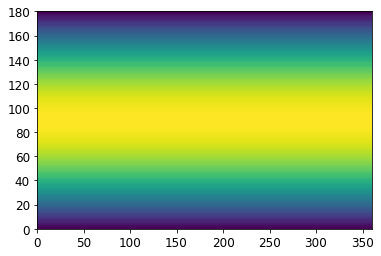

In [45]:
from area import area
obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}
w = area(obj)
print(w/1e6)

calc_ar = np.zeros([180,360])

lats = (cdomask.lat.values)
lons = (cdomask.lon.values)

# print(lats)
# print(lons)

for lat in range(0,180):
    for lon in range(0,360):
        
        tlat = lats[lat]
        ll_lat = tlat - 0.5
        ul_lat = tlat + 0.5
        ur_lat = tlat + 0.5
        lr_lat = tlat - 0.5
        
        tlon = lons[lon] - 180 + 0.5
        ll_lon = tlon - 0.5
        ul_lon = tlon - 0.5
        ur_lon = tlon + 0.5
        lr_lon = tlon + 0.5
        
        lats_poly = [ll_lat, ul_lat, ur_lat, lr_lat]
        lons_poly = [ll_lon, ul_lon, ur_lon, lr_lon]
        
        #calc_ar[lat, lon] = polygon_area(lats_poly, lons_poly)
        obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}
        obj = {'type':'Polygon','coordinates':[[[ll_lon,ll_lat],[ul_lon,ul_lat],[ur_lon,ur_lat],[lr_lon,lr_lat],[ll_lon,ll_lat]]]}
        #obj = {'type':'Polygon','coordinates':[[[-180,-90],[-180,90],[180,90],[180,-90],[-180,-90]]]}

        calc_ar[lat, lon] = area(obj)
        
#         if (lat%10 == 0) & (lon%10 == 0):
#             print(f'{tlat}, {tlon}, {calc_ar[lat, lon]}')

        
plt.figure()
plt.pcolormesh(calc_ar)
print(np.nansum(calc_ar))

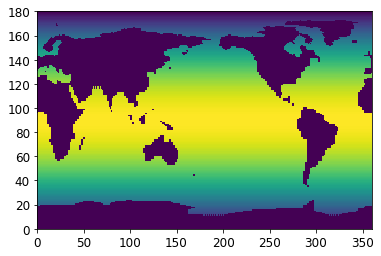

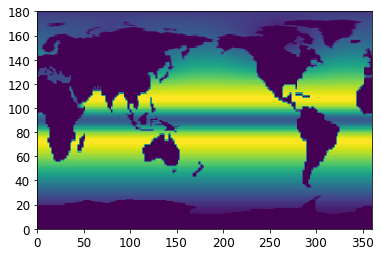

In [46]:
area_masked = (cdomask.aream2[0,:,:].values)
area_notmasked = np.copy(calc_ar)
area_notmasked[area_masked == 0 ] = 0

plt.figure()
plt.pcolormesh(area_notmasked)

plt.figure()
plt.pcolormesh(area_masked)

In [47]:
tmask

<xarray.DataArray 'aream2' (lat: 180, lon: 360)>
array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [8.5022971e+09, 8.5041623e+09, 8.5059748e+09, ..., 8.4907699e+09,
        8.4976492e+09, 8.5003822e+09],
       [8.1228324e+09, 8.1269038e+09, 8.1309773e+09, ..., 8.1106284e+09,
        8.1146926e+09, 8.1187630e+09],
       [7.7222518e+09, 7.7231959e+09, 7.7241411e+09, ..., 7.7194194e+09,
        7.7203615e+09, 7.7213046e+09]], dtype=float32)
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

In [48]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
data_vars = {'tmask':(['lat', 'lon'], area_notmasked,
{'units': 'm2',
'long_name':''}),
             'tmask_noland':(['lat', 'lon'], calc_ar,
{'units': 'm2',
'long_name':''}),
}
# define coordinates
coords = {
'lat': (['lat'], tmask.lat),
'lon': (['lon'], tmask.lon),
}
# define global attributes
attrs = {'made in':'SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb',
'desc': 'I hate mesh masks'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
#ds.to_netcdf(savenam)

### tmask here

In [49]:
savenam = '/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_regridrecalc.nc'
cdomask = xr.open_dataset(savenam)
cdomask
tmask = cdomask.tmask
print(np.nansum(cdomask['tmask_noland'].values))

511207893395811.0


In [50]:
cdomask

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360)
Coordinates:
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    tmask         (lat, lon) float64 ...
    tmask_noland  (lat, lon) float64 1.081e+08 1.081e+08 ... 1.081e+08 1.081e+08
Attributes:
    made in:  SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes....
    desc:     I hate mesh masks

In [51]:
horse = False
if horse:
    tdir = '/gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily/'

    mons = ['01','02','03','04','05','06','07','08','09','10','11','12']
    scens = ['1A','1B','2A','2B','3A','3B']


    for s in scens:
        print(s)
        if s == 'PI':
            yst = 1950
        else:
            yst = 1940
        for y in range(yst,2101):
            print(f'{s},{y}')
            Jan = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m01_wspd10m_extremes.nc')
            Feb = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m02_wspd10m_extremes.nc')
            Mar = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m03_wspd10m_extremes.nc')
            Apr = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m04_wspd10m_extremes.nc')  
            May = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m05_wspd10m_extremes.nc')
            Jun = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m06_wspd10m_extremes.nc')
            Jul = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m07_wspd10m_extremes.nc')
            Aug = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m08_wspd10m_extremes.nc')
            Sep = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m09_wspd10m_extremes.nc')
            Oct = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m10_wspd10m_extremes.nc')  
            Nov = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m11_wspd10m_extremes.nc')
            Dec = xr.open_dataset(f'{tdir}UKESM_{s}_y{y}m12_wspd10m_extremes.nc')

            DJF = np.zeros([90])
            DJF[0:30] = Dec.above95.values
            DJF[30:60] = Jan.above95.values
            DJF[60:90] = Feb.above95.values

            MAM = np.zeros([90])
            MAM[0:30] = Mar.above95.values
            MAM[30:60] = Apr.above95.values
            MAM[60:90] = May.above95.values

            JJA = np.zeros([90])
            JJA[0:30] = Jun.above95.values
            JJA[30:60] = Jul.above95.values
            JJA[60:90] = Aug.above95.values

            SON = np.zeros([90])
            SON[0:30] = Sep.above95.values
            SON[30:60] = Oct.above95.values
            SON[60:90] = Nov.above95.values

            seas_above95 = np.zeros([4])
            seas_above95[0] = np.nanmean(DJF, axis = 0)
            seas_above95[1] = np.nanmean(MAM, axis = 0)
            seas_above95[2] = np.nanmean(JJA, axis = 0)
            seas_above95[3] = np.nanmean(SON, axis = 0)

            DJF = np.zeros([90])
            DJF[0:30] = Dec.above95wt.values
            DJF[30:60] = Jan.above95wt.values
            DJF[60:90] = Feb.above95wt.values

            MAM = np.zeros([90])
            MAM[0:30] = Mar.above95wt.values
            MAM[30:60] = Apr.above95wt.values
            MAM[60:90] = May.above95wt.values

            JJA = np.zeros([90])
            JJA[0:30] = Jun.above95wt.values
            JJA[30:60] = Jul.above95wt.values
            JJA[60:90] = Aug.above95wt.values

            SON = np.zeros([90])
            SON[0:30] = Sep.above95wt.values
            SON[30:60] = Oct.above95wt.values
            SON[60:90] = Nov.above95wt.values

            seas_above95wt = np.zeros([4])
            seas_above95wt[0] = np.nanmean(DJF, axis = 0)
            seas_above95wt[1] = np.nanmean(MAM, axis = 0)
            seas_above95wt[2] = np.nanmean(JJA, axis = 0)
            seas_above95wt[3] = np.nanmean(SON, axis = 0)

            times = pd.to_datetime([f"{y}-01-15", f"{y}-04-15", f"{y}-07-15", f"{y}-10-15"])

            savenam = (f'{tdir}UKESM_{s}_y{y}_wspd10m_seas_extremes.nc')
            data_vars = {'seas_above95wt':(['time_counter'], seas_above95wt,
            {'units': 'm/s',
            'long_name':'10m, mean above 95th percentile'}),
                         'seas_above95':(['time_counter'], seas_above95,
            {'units': 'm/s',
            'long_name':'10m, mean above 95th percentile'}),
            }
            # define coordinates
            coords = {'time_counter': (['time_counter'], times),

            }
            # define global attributes
            attrs = {'made in':'/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb',

            }
            ds = xr.Dataset(data_vars=data_vars,
            coords=coords,
            attrs=attrs)

            ds.to_netcdf(savenam)        


In [52]:
def make_yearlist_era_ex(yrst, yrend):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/daily'
        ty = f'{baseDir}/10m_windspeed_ERA5_{yrs[i]}_extremes.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def make_yearlist_ukesm_ex(yrst, yrend, scen = '1A'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily'
        ty = f'{baseDir}/UKESM_{scen}_y{yrs[i]}_wspd10m_seas_extremes.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

eralist_ex = xr.open_mfdataset(make_yearlist_era_ex(1940, 2019))
ukesmlist_ex = xr.open_mfdataset(make_yearlist_ukesm_ex(1940, 2019))

# cdomask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_krg.nc')
# tmask = cdomask.aream2.mean(dim = 'time_counter')

In [53]:
# test = eralist_ex.above95wt.sel(time=slice(f'{t1}-01-01', f'{t2}-01-01'))
# test2 = test.sel(time=(test['time.season'] == tseas))\
# .groupby('time.year').mean()
# test2
# # axs[i*2+1].plot(test2.year, test2.values, color = 'k')

In [54]:
def make_yearlist_era(yrst, yrend):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/daily'
        ty = f'{baseDir}/ERA5_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def make_yearlist_ukesm(yrst, yrend, scen = '1A'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily'
        ty = f'{baseDir}/UKESM_{scen}_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

eralist = xr.open_mfdataset(make_yearlist_era(1940, 2020))
ukesmlist = xr.open_mfdataset(make_yearlist_ukesm(1940, 2020))

# cdomask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_krg.nc')
# tmask = cdomask.aream2.mean(dim = 'time_counter')

In [55]:
ukesmlist_ex

<xarray.Dataset>
Dimensions:         (time_counter: 320)
Coordinates:
  * time_counter    (time_counter) datetime64[ns] 1940-01-15 ... 2019-10-15
Data variables:
    seas_above95wt  (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
    seas_above95    (time_counter) float64 dask.array<chunksize=(4,), meta=np.ndarray>
Attributes:
    made in:  /gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/M...

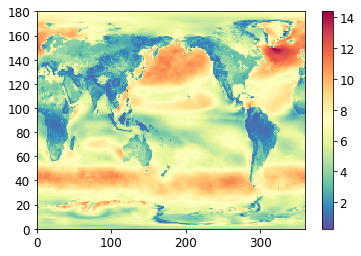

In [56]:
t = eralist.wspd10m.sel(time_counter=slice(f'{1984}-01-01', f'{1985}-01-01'))
            
plt.figure()
w = plt.pcolormesh(t[0,:,:], cmap = 'Spectral_r')                
plt.colorbar(w)

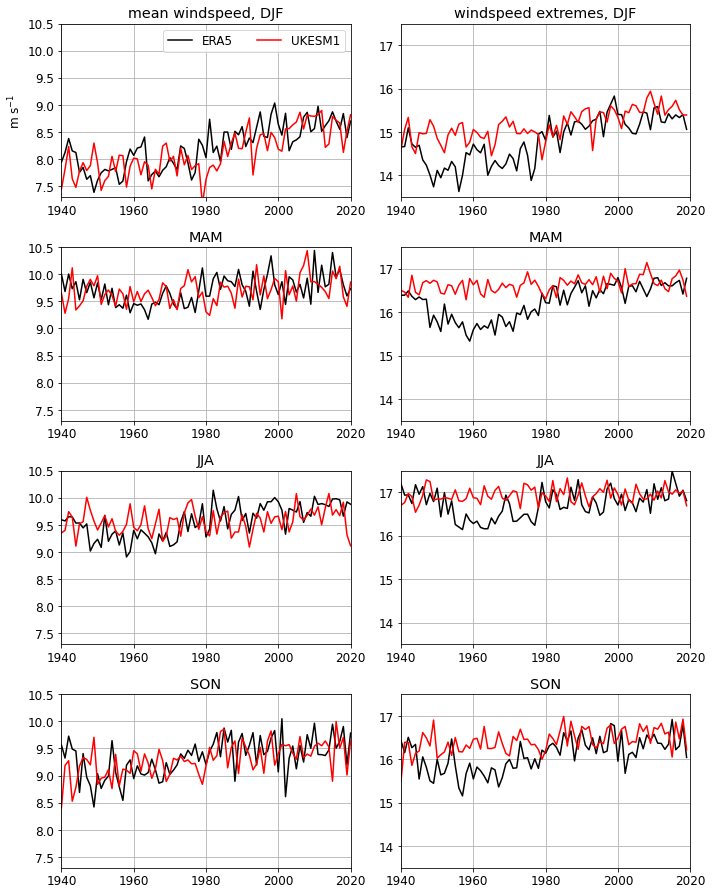

In [57]:
tseas = 'DJF'
t1 = 1940;
t2 = 2021

fact = 0.9
fig, axs = plt.subplots(4,2, figsize=(11*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

seasns = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(0,4):
    tseas = seasns[i]

    test = eralist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i*2].plot(test2.year, test2.values, color = 'k', label = 'ERA5')

    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i*2].plot(test2.year, test2.values, color = 'r', label = 'UKESM1')
    
    ###
    test = eralist_ex.above95wt.sel(time=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.sel(time=(test['time.season'] == tseas))\
    .groupby('time.year').mean()
    axs[i*2+1].plot(test2.year, test2.values, color = 'k')

    test = ukesmlist_ex.seas_above95wt.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i*2+1].plot(test2.year, test2.values, color = 'r')
    
tits  = ['mean windspeed, DJF','windspeed extremes, DJF',
        'MAM','MAM',
        'JJA','JJA',
        'SON','SON']

tmim = 7.3; tmam = 10.5
tmie = 13.5; tmae = 17.5

mis = [tmim,tmie,tmim,tmie,tmim,tmie,tmim,tmie]
mas = [tmam,tmae,tmam,tmae,tmam,tmae,tmam,tmae]
for p in range(0,8):
    axs[p].grid(); 
    axs[p].set_xticks(np.arange(1940,2050,20), fontsize = 10)
    axs[p].set_xlim([1940,2020])
    if p == 0:
        axs[p].set_ylabel('m s$^{-1}$')
        #axs[p].set_ylim([6.5,16])
    axs[p].set_title(tits[p])
    
    axs[0].legend(ncol = 2, loc = 'best')
    axs[p].set_ylim([mis[p], mas[p]])
    
plt.tight_layout()

In [58]:
data = np.zeros([5,6])
df = pd.DataFrame(data, columns=['trend-1940-1980','p-1940-1980', 'trend-1980-2020','p-1980-2020','trend-1940-2020','p-1940-2020', ],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])

df

,trend-1940-1980,p-1940-1980,trend-1980-2020,p-1980-2020,trend-1940-2020,p-1940-2020
full year,0.0,0.0,0.0,0.0,0.0,0.0
DJF,0.0,0.0,0.0,0.0,0.0,0.0
MAM,0.0,0.0,0.0,0.0,0.0,0.0
JJA,0.0,0.0,0.0,0.0,0.0,0.0
SON,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
import pymannkendall as mk
data = np.zeros([5,6])
# test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
# test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
# .mean(dim = ['lat', 'lon'])\
# .sel(time_counter=(test['time_counter.season'] == tseas))\
# .groupby('time_counter.year').mean()
data = np.zeros([5,6])
seas = ['DJF','MAM', 'JJA', 'SON',]

yr = 1940; yrend = 1980
test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'UKESM {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,0] = slope*10; data[0,1] = p 
for i in range(0,4):
    tseas = seas[i]
    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'UKESM {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,0] = slope*10; data[i+1,1] = p 

yr = 1980; yrend = 2020
test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'UKESM {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,2] = slope*10; data[0,3] = p 
for i in range(0,4):
    tseas = seas[i]
    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'UKESM {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,2] = slope*10; data[i+1,3] = p 

yr = 1940; yrend = 2020
test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'UKESM {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,4] = slope*10; data[0,5] = p 
for i in range(0,4):
    tseas = seas[i]
    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'UKESM {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,4] = slope*10; data[i+1,5] = p 


df_UKESM_wt = pd.DataFrame(data, columns=['trend-1940-1980','p-1940-1980', 'trend-1980-2020','p-1980-2020','trend-1940-2020','p-1940-2020', ],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df_UKESM_wt.attrs = {"made in": 'SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb'}
df_UKESM_wt.to_csv('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/csvs/MK_UKESM_1940-2020.csv')



UKESM 1940-1980, full year: no trend, slope (per year) 0.0040492064989430445, p 0.08256310085481289
UKESM 1940-1980, DJF: no trend, slope (per year) 0.003967201770393313, p 0.27856604965694465
UKESM 1940-1980, MAM: no trend, slope (per year) 0.003582773584390883, p 0.29976285312958106
UKESM 1940-1980, JJA: no trend, slope (per year) 0.002510020293263858, p 0.49182374314403665
UKESM 1940-1980, SON: no trend, slope (per year) 0.004077793046244477, p 0.24872473553918217
UKESM 1980-2020, full year: increasing, slope (per year) 0.009874649336396401, p 1.903412986026254e-05
UKESM 1980-2020, DJF: increasing, slope (per year) 0.021210237751237343, p 1.7139117947539972e-05
UKESM 1980-2020, MAM: increasing, slope (per year) 0.008116518158783684, p 0.041456909675791964
UKESM 1980-2020, JJA: increasing, slope (per year) 0.008462215429795892, p 0.00431041611784333
UKESM 1980-2020, SON: no trend, slope (per year) 0.0021816775110431257, p 0.47726203508105103
UKESM 1940-2020, full year: increasing, sl

In [60]:
import pymannkendall as mk
data = np.zeros([5,6])
# test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
# test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
# .mean(dim = ['lat', 'lon'])\
# .sel(time_counter=(test['time_counter.season'] == tseas))\
# .groupby('time_counter.year').mean()

seas = ['DJF','MAM', 'JJA', 'SON',]

yr = 1940; yrend = 1980
test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'era {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,0] = slope*10; data[0,1] = p 
for i in range(0,4):
    tseas = seas[i]
    test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'era {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,0] = slope*10; data[i+1,1] = p 

yr = 1980; yrend = 2020
test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'era {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,2] = slope*10; data[0,3] = p 
for i in range(0,4):
    tseas = seas[i]
    test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'era {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,2] = slope*10; data[i+1,3] = p 

yr = 1940; yrend = 2020
test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'era {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,4] = slope*10; data[0,5] = p 
for i in range(0,4):
    tseas = seas[i]
    test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'era {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,4] = slope*10; data[i+1,5] = p 


df_era_wt = pd.DataFrame(data, columns=['trend-1940-1980','p-1940-1980', 'trend-1980-2020','p-1980-2020','trend-1940-2020','p-1940-2020', ],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df_era_wt.attrs = {"made in": 'SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb'}
df_era_wt.to_csv('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/csvs/MK_era_1940-2020.csv')



era 1940-1980, full year: no trend, slope (per year) 0.0005304447341342973, p 0.8796101413969479
era 1940-1980, DJF: no trend, slope (per year) 0.0036298401271201612, p 0.28903354254194413
era 1940-1980, MAM: decreasing, slope (per year) -0.008478530181063836, p 0.006633762413644773
era 1940-1980, JJA: no trend, slope (per year) -0.0019146902460727548, p 0.7354536181171747
era 1940-1980, SON: no trend, slope (per year) 0.007542135455342805, p 0.19591947802979215
era 1980-2020, full year: increasing, slope (per year) 0.005046134376226608, p 0.029350731060459267
era 1980-2020, DJF: increasing, slope (per year) 0.011527610960327393, p 0.0029681843036870603
era 1980-2020, MAM: no trend, slope (per year) 0.0021781070838351423, p 0.5216481488445233
era 1980-2020, JJA: increasing, slope (per year) 0.006984401824817077, p 0.014889064489253423
era 1980-2020, SON: no trend, slope (per year) -5.970133663610433e-05, p 0.9907040297231748
era 1940-2020, full year: increasing, slope (per year) 0.0090

In [61]:
print(df_UKESM_wt)

           trend-1940-1980  p-1940-1980  trend-1980-2020  p-1980-2020  \
full year         0.040492     0.082563         0.098746     0.000019   
DJF               0.039672     0.278566         0.212102     0.000017   
MAM               0.035828     0.299763         0.081165     0.041457   
JJA               0.025100     0.491824         0.084622     0.004310   
SON               0.040778     0.248725         0.021817     0.477262   

           trend-1940-2020   p-1940-2020  
full year         0.065244  6.157075e-12  
DJF               0.131761  4.334533e-12  
MAM               0.034431  6.836914e-03  
JJA               0.024279  2.407178e-02  
SON               0.070259  1.051601e-06  


In [62]:
print(df_era_wt)

           trend-1940-1980  p-1940-1980  trend-1980-2020  p-1980-2020  \
full year         0.005304     0.879610         0.050461     0.029351   
DJF               0.036298     0.289034         0.115276     0.002968   
MAM              -0.084785     0.006634         0.021781     0.521648   
JJA              -0.019147     0.735454         0.069844     0.014889   
SON               0.075421     0.195919        -0.000597     0.990704   

           trend-1940-2020   p-1940-2020  
full year         0.090958  1.551315e-11  
DJF               0.137024  9.392487e-14  
MAM               0.037229  6.028414e-03  
JJA               0.087614  1.214852e-09  
SON               0.081676  4.778528e-06  


In [63]:
def make_yearlist_era_ex(yrst, yrend):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/daily'
        ty = f'{baseDir}/10m_windspeed_ERA5{yrs[i]}_extremes.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

def make_yearlist_ukesm_ex(yrst, yrend, scen = '1A'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        baseDir = '/gpfs/data/greenocean/software/products/windsFromComponents/symlinked_hrly_UKESM/daily'
        ty = f'{baseDir}/UKESM_{scen}_y{yrs[i]}_wspd10m_seas_rg.nc'
        t2 = glob.glob(ty)
        ylist.append(t2[0])
    return ylist

eralist = xr.open_mfdataset(make_yearlist_era(1940, 2020))
ukesmlist = xr.open_mfdataset(make_yearlist_ukesm(1940, 2020))

# cdomask = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/PlankTOMmask_krg.nc')
# tmask = cdomask.aream2.mean(dim = 'time_counter')

w = xr.open_dataset('/gpfs/data/greenocean/software/products/windsFromComponents/ERA5_v202303_rawdat/daily/10m_windspeed_ERA5_2021_extremes.nc')
w

<xarray.Dataset>
Dimensions:    (time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    at95       (time) float64 ...
    above95    (time) float64 ...
    above95wt  (time) float64 ...
Attributes:
    made in:  SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb
    desc:     yearly medusa files, saving only variables of interest

## SAM vs wind speed

In [64]:
tw = pd.read_csv('./sam/sam_reformat.txt', sep = ',')

d = pd.date_range(start='1/1/1957', end='12/1/2022', freq='MS')    
sam = np.random.rand(len(d))


ind = 0
for y in range(1957,2023):
    ty = np.array(tw.loc[tw['YEAR'] == y].values)

    sams = (ty[0][1:13])
    sam[ind:ind+12] = sams
    ind = ind+12

# plt.figure()
# plt.plot(d,sam)

# print(sam[600])
# print(d[600])

savenam = './sam/sam.nc'
data_vars = {'SAM':(['time_counter'], sam,
{'units': 'sam index',
'long_name':'SAM index, see Gareth Marshall'}),
}
# define coordinates
coords = {'time_counter': (['time_counter'], d),
          }
# define global attributes
attrs = {'made in':'SOZONE/MEDUSA/makeYearlyMEDUSAsubsetfiles.ipynb',
'desc': 'yearly medusa files, saving only variables of interest'
}
ds = xr.Dataset(data_vars=data_vars,
coords=coords,
attrs=attrs)
#ds.to_netcdf(savenam)

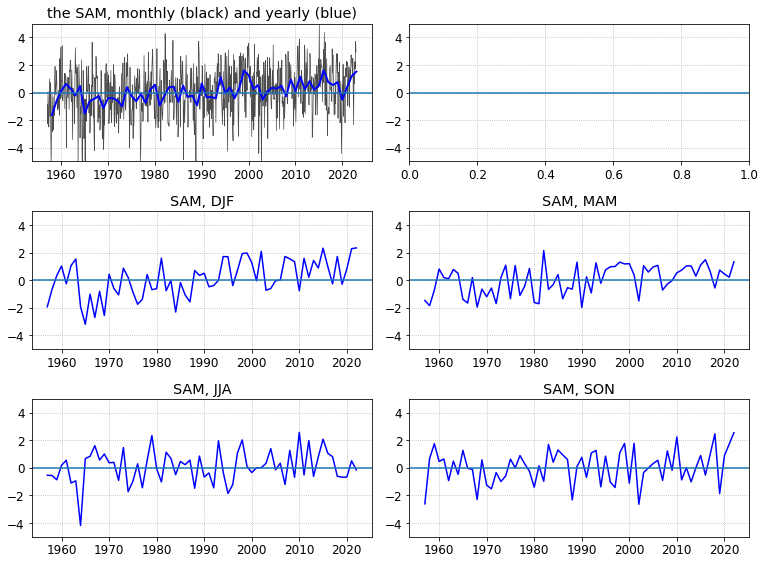

In [65]:
tsam = xr.open_dataset('./sam/sam.nc')

fact = 0.4
fig, axs = plt.subplots(3,2, figsize=(27*fact, 20*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(tsam.time_counter,tsam.SAM, linewidth = 0.7, alpha = 0.7, color = 'k')
sam_yr = tsam.groupby('time_counter.year').mean()
times = pd.date_range(f"{1957}/06/01",f"{2023}/06/01",freq='Y',closed='right')
axs[0].plot(times, sam_yr.SAM, linewidth = 2, color = 'b')
axs[0].set_title('the SAM, monthly (black) and yearly (blue)')
seasns = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(0,4):
    tseas = seasns[i]
    sam_yr = tsam.sel(time_counter=(tsam['time_counter.season'] == seasns[i])).groupby('time_counter.year').mean()
    axs[i+2].plot(sam_yr.year, sam_yr.SAM, color = 'b')
    axs[i+2].set_title(f'SAM, {seasns[i]}')


for i in range(0,6):
    axs[i].axhline(y = 0)
    axs[i].grid(linestyle = ':')
    axs[i].set_ylim([-5,5])

plt.tight_layout()

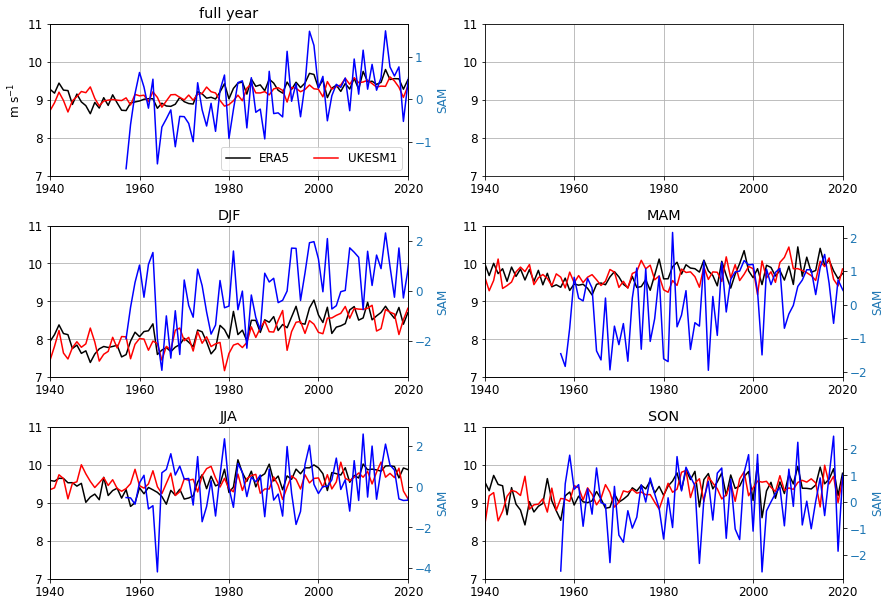

In [66]:
tseas = 'DJF'
t1 = 1940;
t2 = 2021

fact = 0.66
fig, axs = plt.subplots(3,2, figsize=(19*fact, 13*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()


test = eralist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
axs[0].plot(test2.year, test2.values, color = 'k', label = 'ERA5')

test = ukesmlist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
axs[0].plot(test2.year, test2.values, color = 'r', label = 'UKESM1')

ax2 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('SAM', color=color)
ax2.tick_params(axis='y', labelcolor=color)
sam_yr = tsam.groupby('time_counter.year').mean()
ax2.plot(sam_yr.year, sam_yr.SAM, color = 'b')
axs[0].set_title('full year')

seasns = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(0,4):
    tseas = seasns[i]

    test = eralist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i+2].plot(test2.year, test2.values, color = 'k', label = 'ERA5')

    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i+2].plot(test2.year, test2.values, color = 'r', label = 'UKESM1')
    
    ax2 = axs[i+2].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('SAM', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    sam_yr = tsam.sel(time_counter=(tsam['time_counter.season'] == seasns[i])).groupby('time_counter.year').mean()
    ax2.plot(sam_yr.year, sam_yr.SAM, color = 'b')

    
tits  = ['full year','','DJF', 'MAM', 'JJA', 'SON']

tmim = 7.0; tmam = 11
tmie = 13.5; tmae = 17.5

mis = [tmim,tmim,tmim,tmim,tmim,tmim,tmim,tmim]
mas = [tmam,tmam,tmam,tmam,tmam,tmam,tmam,tmam]

for p in range(0,6):
    axs[p].grid(); 
    axs[p].set_xticks(np.arange(1940,2050,20), fontsize = 10)
    axs[p].set_xlim([1940,2020])
    if p == 0:
        axs[p].set_ylabel('m s$^{-1}$')
        #axs[p].set_ylim([6.5,16])
    axs[p].set_title(tits[p])
    
    axs[0].legend(ncol = 2, loc = 'lower right')
    axs[p].set_ylim([mis[p], mas[p]])
    
plt.tight_layout()

## mann-kendall 1960-2020

In [67]:
import pymannkendall as mk
data = np.zeros([5,8])
seas = ['DJF','MAM', 'JJA', 'SON',]

yr = 1957; yrend = 1980
test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'UKESM {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,0] = slope*10; data[0,1] = p 
for i in range(0,4):
    tseas = seas[i]
    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'UKESM {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,0] = slope*10; data[i+1,1] = p 

yr = 1980; yrend = 2000
test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'UKESM {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,2] = slope*10; data[0,3] = p 
for i in range(0,4):
    tseas = seas[i]
    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'UKESM {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,2] = slope*10; data[i+1,3] = p 

yr = 2000; yrend = 2020
test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'UKESM {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,4] = slope*10; data[0,5] = p 
for i in range(0,4):
    tseas = seas[i]
    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'UKESM {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,4] = slope*10; data[i+1,5] = p 

yr = 1957; yrend = 2020
test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'UKESM {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,6] = slope*10; data[0,7] = p 
for i in range(0,4):
    tseas = seas[i]
    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'UKESM {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,6] = slope*10; data[i+1,7] = p     

df_UKESM = pd.DataFrame(data, columns=['trend-1960-1980','p-1960-1980', 'trend-1980-2000','p-1980-2000',\
                                       'trend-2000-2020','p-2000-2020',\
                                       'trend-1960-2020','p-1960-2020', ],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df_UKESM.attrs = {"made in": 'SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb'}
df_UKESM.to_csv('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/csvs/MK_UKESM_1960-2020.csv')



UKESM 1957-1980, full year: no trend, slope (per year) 0.004152521307594646, p 0.2244114837865725
UKESM 1957-1980, DJF: no trend, slope (per year) -0.002089147860700269, p 0.8740921801633093
UKESM 1957-1980, MAM: no trend, slope (per year) 0.010183428512213667, p 0.11305101958707042
UKESM 1957-1980, JJA: no trend, slope (per year) 0.010318259164076396, p 0.20490442371975082
UKESM 1957-1980, SON: no trend, slope (per year) -0.006665318755027035, p 0.42817779030963843
UKESM 1980-2000, full year: increasing, slope (per year) 0.015508877945180966, p 0.021248244387927828
UKESM 1980-2000, DJF: increasing, slope (per year) 0.038284413033694634, p 0.005819816954009793
UKESM 1980-2000, MAM: increasing, slope (per year) 0.020038361733386502, p 0.047804597893902345
UKESM 1980-2000, JJA: no trend, slope (per year) 0.0067790434984118225, p 0.5376032363488861
UKESM 1980-2000, SON: no trend, slope (per year) -0.00026277263339500066, p 0.8711314915971582
UKESM 2000-2020, full year: no trend, slope (pe

In [68]:
import pymannkendall as mk
data = np.zeros([5,8])
seas = ['DJF','MAM', 'JJA', 'SON',]

yr = 1957; yrend = 1980
test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'era {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,0] = slope*10; data[0,1] = p 
for i in range(0,4):
    tseas = seas[i]
    test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'era {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,0] = slope*10; data[i+1,1] = p 

yr = 1980; yrend = 2000
test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'era {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,2] = slope*10; data[0,3] = p 
for i in range(0,4):
    tseas = seas[i]
    test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'era {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,2] = slope*10; data[i+1,3] = p 

yr = 2000; yrend = 2020
test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'era {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,4] = slope*10; data[0,5] = p 
for i in range(0,4):
    tseas = seas[i]
    test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'era {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,4] = slope*10; data[i+1,5] = p 

yr = 1957; yrend = 2020
test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
.mean(dim = ['lat', 'lon'])\
.groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test2)
print(f'era {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,6] = slope*10; data[0,7] = p 
for i in range(0,4):
    tseas = seas[i]
    test = eralist.wspd10m.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test2)
    print(f'era {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,6] = slope*10; data[i+1,7] = p     

df_era = pd.DataFrame(data, columns=['trend-1960-1980','p-1960-1980', 'trend-1980-2000','p-1980-2000',\
                                       'trend-2000-2020','p-2000-2020',\
                                       'trend-1960-2020','p-1960-2020', ],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df_era.attrs = {"made in": 'SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb'}
df_era.to_csv('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/csvs/MK_era_1960-2020.csv')



era 1957-1980, full year: increasing, slope (per year) 0.01454781775243239, p 0.005118048858841595
era 1957-1980, DJF: no trend, slope (per year) 0.007824277688733084, p 0.3692092650321579
era 1957-1980, MAM: no trend, slope (per year) 0.008295315842355766, p 0.15382082239203032
era 1957-1980, JJA: increasing, slope (per year) 0.020758550303862044, p 0.011231776901026835
era 1957-1980, SON: increasing, slope (per year) 0.02396813524422073, p 0.0018305274191598997
era 1980-2000, full year: no trend, slope (per year) 0.012869102787351039, p 0.07435290536856365
era 1980-2000, DJF: increasing, slope (per year) 0.028190858370204897, p 0.021248244387927828
era 1980-2000, MAM: no trend, slope (per year) 0.002720090218699016, p 0.7702877264736667
era 1980-2000, JJA: increasing, slope (per year) 0.02076369897042195, p 0.047804597893902345
era 1980-2000, SON: no trend, slope (per year) 0.006373923116599197, p 0.5812547604118179
era 2000-2020, full year: no trend, slope (per year) 0.0135048252464

In [69]:
import pymannkendall as mk
data = np.zeros([5,8])
seas = ['DJF','MAM', 'JJA', 'SON',]

yr = 1957; yrend = 1980
test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))\
    .groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test)
print(f'sam {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,0] = slope*10; data[0,1] = p 
for i in range(0,4):
    tseas = seas[i]
    test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test = test.sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test)
    print(f'sam {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,0] = slope*10; data[i+1,1] = p 

yr = 1980; yrend = 2000
test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))\
    .groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test)
print(f'sam {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,2] = slope*10; data[0,3] = p 
for i in range(0,4):
    tseas = seas[i]
    test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test = test.sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test)
    print(f'sam {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,2] = slope*10; data[i+1,3] = p 

yr = 2000; yrend = 2020
test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))\
    .groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test)
print(f'sam {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,4] = slope*10; data[0,5] = p 
for i in range(0,4):
    tseas = seas[i]
    test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test = test.sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test)
    print(f'sam {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,4] = slope*10; data[i+1,5] = p 
        
yr = 1957; yrend = 2020
test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))\
    .groupby('time_counter.year').mean()
trend, h, p, z, Tau, s, var_s, slope, intercept \
    = mk.original_test(test)
print(f'sam {yr}-{yrend}, full year: {trend}, slope (per year) {slope}, p {p}')
data[0,6] = slope*10; data[0,7] = p 
for i in range(0,4):
    tseas = seas[i]
    test = tsam.SAM.sel(time_counter=slice(f'{yr}-01-01', f'{yrend}-01-01'))
    test = test.sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    trend, h, p, z, Tau, s, var_s, slope, intercept \
        = mk.original_test(test)
    print(f'sam {yr}-{yrend}, {tseas}: {trend}, slope (per year) {slope}, p {p}')
    data[i+1,6] = slope*10; data[i+1,7] = p    

df_sam = pd.DataFrame(data, columns=['trend-1960-1980','p-1960-1980', 'trend-1980-2000','p-1980-2000',\
                                       'trend-2000-2020','p-2000-2020',\
                                       'trend-1960-2020','p-1960-2020', ],\
                  index  = ['full year','DJF','MAM', 'JJA', 'SON',])
df_sam.attrs = {"made in": 'SOZONE/windAnalyis/wspdComponents/MannKendall-andMeansExtremes.ipynb'}
df_sam.to_csv('/gpfs/home/mep22dku/scratch/SOZONE/windAnalyis/wspdComponents/csvs/MK_SAM_1960-2020.csv')



sam 1957-1980, full year: no trend, slope (per year) 0.01699652777777776, p 0.5030370130775135
sam 1957-1980, DJF: no trend, slope (per year) -0.0007142857142857361, p 0.9802109790485438
sam 1957-1980, MAM: no trend, slope (per year) 0.02095238095238095, p 0.3551279523916375
sam 1957-1980, JJA: no trend, slope (per year) 0.04368421052631579, p 0.5261780967197713
sam 1957-1980, SON: no trend, slope (per year) -0.011666666666666672, p 0.6726109872286647
sam 1980-2000, full year: increasing, slope (per year) 0.0708125, p 0.03719769372912385
sam 1980-2000, DJF: increasing, slope (per year) 0.150952380952381, p 0.0027943875916636163
sam 1980-2000, MAM: increasing, slope (per year) 0.12354166666666663, p 0.017863627708934793
sam 1980-2000, JJA: no trend, slope (per year) 0.008311403508771933, p 0.9741177473553713
sam 1980-2000, SON: no trend, slope (per year) 0.03246031746031746, p 0.5812547604118179
sam 2000-2020, full year: no trend, slope (per year) 0.02277777777777778, p 0.13896689395673

In [70]:
print('ukesm')
print(df_UKESM)
print()
print('era')
print(df_era)
print()
print('sam')
print(df_sam)

ukesm
           trend-1960-1980  p-1960-1980  trend-1980-2000  p-1980-2000  \
full year         0.041525     0.224411         0.155089     0.021248   
DJF              -0.020891     0.874092         0.382844     0.005820   
MAM               0.101834     0.113051         0.200384     0.047805   
JJA               0.103183     0.204904         0.067790     0.537603   
SON              -0.066653     0.428178        -0.002628     0.871131   

           trend-2000-2020  p-2000-2020  trend-1960-2020   p-1960-2020  
full year         0.037398     0.626496         0.075529  4.068716e-10  
DJF               0.061165     0.721176         0.164398  8.637464e-10  
MAM              -0.036046     0.770288         0.045939  6.140865e-03  
JJA               0.105333     0.183447         0.037559  1.883850e-02  
SON               0.036175     0.871131         0.065027  5.566661e-04  

era
           trend-1960-1980  p-1960-1980  trend-1980-2000  p-1980-2000  \
full year         0.145478     0.005118

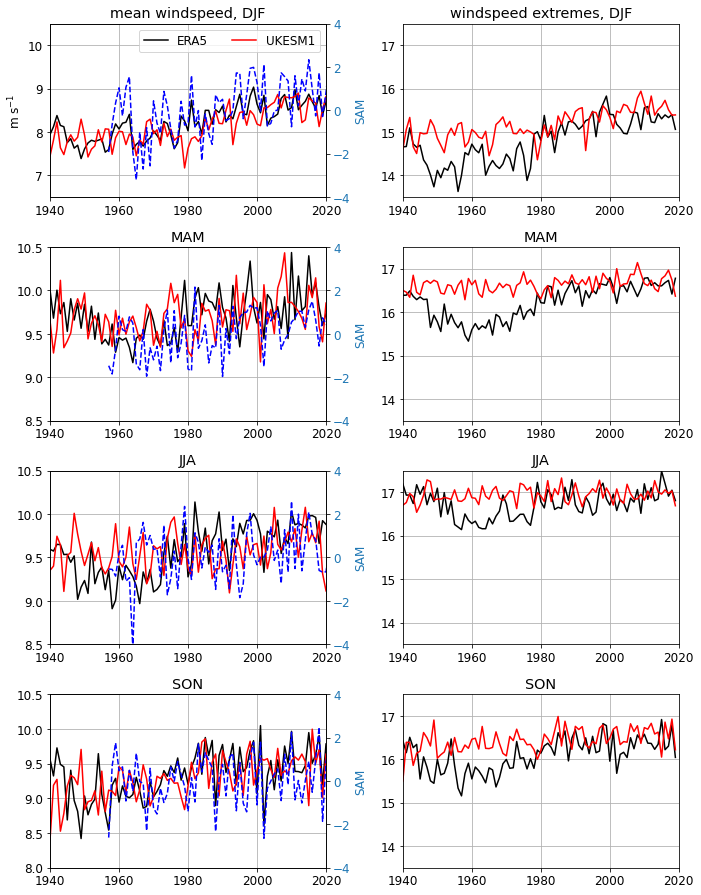

In [76]:
tseas = 'DJF'
t1 = 1940;
t2 = 2021

fact = 0.9
fig, axs = plt.subplots(4,2, figsize=(11*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

seasns = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(0,4):
    tseas = seasns[i]

    test = eralist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i*2].plot(test2.year, test2.values, color = 'k', label = 'ERA5')

    test = ukesmlist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
    .mean(dim = ['lat', 'lon'])\
    .sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i*2].plot(test2.year, test2.values, color = 'r', label = 'UKESM1')
    
    ###
    test = eralist_ex.above95wt.sel(time=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.sel(time=(test['time.season'] == tseas))\
    .groupby('time.year').mean()
    axs[i*2+1].plot(test2.year, test2.values, color = 'k')

    test = ukesmlist_ex.seas_above95wt.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
    test2 = test.sel(time_counter=(test['time_counter.season'] == tseas))\
    .groupby('time_counter.year').mean()
    axs[i*2+1].plot(test2.year, test2.values, color = 'r')
    
tits  = ['mean windspeed, DJF','windspeed extremes, DJF',
        'MAM','MAM',
        'JJA','JJA',
        'SON','SON']

tmim = 7.3; tmam = 10.5
tmie = 13.5; tmae = 17.5

mis = [6.5,tmie,8.5,tmie,8.5,tmie,8,tmie]
mas = [tmam,tmae,tmam,tmae,tmam,tmae,tmam,tmae]
for p in range(0,8):
    axs[p].grid(); 
    axs[p].set_xticks(np.arange(1940,2050,20), fontsize = 10)
    axs[p].set_xlim([1940,2020])
    if p == 0:
        axs[p].set_ylabel('m s$^{-1}$')
        #axs[p].set_ylim([6.5,16])
    axs[p].set_title(tits[p])
    
    axs[0].legend(ncol = 2, loc = 'best')
    axs[p].set_ylim([mis[p], mas[p]])
    
    
seasns = ['DJF', 'MAM', 'JJA', 'SON']
for i in range(0,4):
    tseas = seasns[i]

#     test = eralist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
#     test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
#     .mean(dim = ['lat', 'lon'])\
#     .sel(time_counter=(test['time_counter.season'] == tseas))\
#     .groupby('time_counter.year').mean()
#     axs[i*2].plot(test2.year, test2.values, color = 'k', label = 'ERA5')

#     test = ukesmlist.wspd10m.sel(time_counter=slice(f'{t1}-01-01', f'{t2}-01-01'))
#     test2 = test.isel(lat = slice(0,40)).weighted(tmask.isel(lat = slice(0,40)))\
#     .mean(dim = ['lat', 'lon'])\
#     .sel(time_counter=(test['time_counter.season'] == tseas))\
#     .groupby('time_counter.year').mean()
#     axs[i+2].plot(test2.year, test2.values, color = 'r', label = 'UKESM1')
    
    ax2 = axs[i*2].twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('SAM', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    sam_yr = tsam.sel(time_counter=(tsam['time_counter.season'] == seasns[i])).groupby('time_counter.year').mean()
    ax2.plot(sam_yr.year, sam_yr.SAM, color = 'b', linestyle = '--')
    ax2.set_ylim([-4,4])

    
plt.tight_layout()